In [1]:
# Copyright 2019 Google Inc.

# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at

#     http://www.apache.org/licenses/LICENSE-2.0

# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

In [2]:
import tensorflow as tf

/home/max/anaconda3/envs/tf-hub/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:523: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/max/anaconda3/envs/tf-hub/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:524: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/max/anaconda3/envs/tf-hub/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:525: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/max/anaconda3/envs/tf-hub/lib/python3.6/site-pack

In [4]:
from tensorflow import keras
import os
import re

from sklearn.model_selection import train_test_split
import pandas as pd
import tensorflow as tf
import tensorflow_hub as hub
from datetime import datetime

# predicted logits to distribution
import numpy as np

# confusion matrix
from matplotlib import pyplot as plt
import itertools

from sklearn.metrics import f1_score

In [5]:
print(tf.__version__)

1.12.0


In [6]:
dataset = 'hatespeech'

current = os.getcwd()
basefolder = current + '/dataset_'+ dataset+'/'
datafolder = basefolder + 'data/'  # for example /dataset_businessnews/data/
print(basefolder)

infolder =  basefolder + 'input/'
outfolder = basefolder + 'output/'

/home/max/git/modelcompare/dataset_hatespeech/


### classification with TF-HUB and BERT

In [7]:
# modified to multilabel classification from binary example:
# https://github.com/google-research/bert/blob/master/predicting_movie_reviews_with_bert_on_tf_hub.ipynb

# original way in example for metrics, F1, False Negatives etc does not work for multi lable. 
# They use tf.metric.recall etc. which cast labels to boolean, returning incorrect values for multi label.

In [8]:
# optional, load local environment: source activate tf-hub

#Predicting Movie Review Sentiment with BERT on TF Hub

If you’ve been following Natural Language Processing over the past year, you’ve probably heard of BERT: Bidirectional Encoder Representations from Transformers. It’s a neural network architecture designed by Google researchers that’s totally transformed what’s state-of-the-art for NLP tasks, like text classification, translation, summarization, and question answering.

Now that BERT's been added to [TF Hub](https://www.tensorflow.org/hub) as a loadable module, it's easy(ish) to add into existing Tensorflow text pipelines. In an existing pipeline, BERT can replace text embedding layers like ELMO and GloVE. Alternatively, [finetuning](http://wiki.fast.ai/index.php/Fine_tuning) BERT can provide both an accuracy boost and faster training time in many cases.

Here, we'll train a model to predict whether an IMDB movie review is positive or negative using BERT in Tensorflow with tf hub. Some code was adapted from [this colab notebook](https://colab.sandbox.google.com/github/tensorflow/tpu/blob/master/tools/colab/bert_finetuning_with_cloud_tpus.ipynb). Let's get started!

In addition to the standard libraries we imported above, we'll need to install BERT's python package.

In [9]:
#!pip install bert-tensorflow

In [10]:
import bert
from bert import run_classifier
from bert import optimization
from bert import tokenization

Below, we'll set an output directory location to store our model output and checkpoints. This can be a local directory, in which case you'd set OUTPUT_DIR to the name of the directory you'd like to create. If you're running this code in Google's hosted Colab, the directory won't persist after the Colab session ends.

Alternatively, if you're a GCP user, you can store output in a GCP bucket. To do that, set a directory name in OUTPUT_DIR and the name of the GCP bucket in the BUCKET field.

Set DO_DELETE to rewrite the OUTPUT_DIR if it exists. Otherwise, Tensorflow will load existing model checkpoints from that directory (if they exist).

In [11]:
# create directory if need
OUTPUT_DIR = 'tf-hub-output'#@param {type:"string"}

In [12]:
train = pd.read_csv(basefolder+'input/train.csv',sep='\t', header = None)
dev = pd.read_csv(basefolder+'input/dev.csv'  ,sep='\t', header = None)
#test.to_csv('input/test.csv',sep='\t', index = False, header = False)

train.columns = ['id','label','text']
dev.columns  = ['id','label', 'text']

In [13]:
print(len(train))

18783


In [14]:
# Test smaller
trainsize = 9000
train = train[0:trainsize]

In [15]:
train.head()

,id,label,text
0,14272,1,Pumpkin spice Marlboro ' s for da hoes
1,1671,1,MENTION ; MENTION : What things do you love...
2,23584,2,Yankees should have NEVER gave away Melky . G...
3,3591,1,MENTION I love Louis CK ! Quit bein a faggot...
4,13318,1,My boyfriend is such a smart ass bitch watch y...


In [16]:
dev.head()

,id,label,text
0,14206,2,"Please stop scoring , otherwise you won ' t h..."
1,16354,2,RT MENTION : IF A SINGLE WASP COULD READ THE...
2,21621,1,Still waiting for oomf to hit that hoe lololol
3,5899,1,MENTION I agree the fat bitches the only girl...
4,19499,2,RT MENTION : Me and MENTION are in our yell...


In [17]:
print(len(train))
print(len(dev))

9000
3000


In [18]:
DATA_COLUMN = 'text'
LABEL_COLUMN = 'label'
# label_list is the list of labels, i.e. True, False or 0, 1 or 'dog', 'cat'
label_list = [0, 1, 2]

#Data Preprocessing
We'll need to transform our data into a format BERT understands. This involves two steps. First, we create  `InputExample`'s using the constructor provided in the BERT library.

- `text_a` is the text we want to classify, which in this case, is the `Request` field in our Dataframe. 
- `text_b` is used if we're training a model to understand the relationship between sentences (i.e. is `text_b` a translation of `text_a`? Is `text_b` an answer to the question asked by `text_a`?). This doesn't apply to our task, so we can leave `text_b` blank.
- `label` is the label for our example, i.e. True, False

In [19]:
# Use the InputExample class from BERT's run_classifier code to create examples from the data
train_InputExamples = train.apply(lambda x: bert.run_classifier.InputExample(guid=None, # Globally unique ID for bookkeeping, unused in this example
                                                                   text_a = x[DATA_COLUMN], 
                                                                   text_b = None, 
                                                                   label = x[LABEL_COLUMN]), axis = 1)

dev_InputExamples = dev.apply(lambda x: bert.run_classifier.InputExample(guid=None, 
                                                                   text_a = x[DATA_COLUMN], 
                                                                   text_b = None, 
                                                                   label = x[LABEL_COLUMN]), axis = 1)

Next, we need to preprocess our data so that it matches the data BERT was trained on. For this, we'll need to do a couple of things (but don't worry--this is also included in the Python library):


1. Lowercase our text (if we're using a BERT lowercase model)
2. Tokenize it (i.e. "sally says hi" -> ["sally", "says", "hi"])
3. Break words into WordPieces (i.e. "calling" -> ["call", "##ing"])
4. Map our words to indexes using a vocab file that BERT provides
5. Add special "CLS" and "SEP" tokens (see the [readme](https://github.com/google-research/bert))
6. Append "index" and "segment" tokens to each input (see the [BERT paper](https://arxiv.org/pdf/1810.04805.pdf))

Happily, we don't have to worry about most of these details.




To start, we'll need to load a vocabulary file and lowercasing information directly from the BERT tf hub module:

In [20]:
# This is a path to an uncased (all lowercase) version of BERT
BERT_MODEL_HUB = "https://tfhub.dev/google/bert_uncased_L-12_H-768_A-12/1"

def create_tokenizer_from_hub_module():
  """Get the vocab file and casing info from the Hub module."""
  with tf.Graph().as_default():
    bert_module = hub.Module(BERT_MODEL_HUB)
    tokenization_info = bert_module(signature="tokenization_info", as_dict=True)
    with tf.Session() as sess:
      vocab_file, do_lower_case = sess.run([tokenization_info["vocab_file"],
                                            tokenization_info["do_lower_case"]])
      
  return bert.tokenization.FullTokenizer(
      vocab_file=vocab_file, do_lower_case=do_lower_case)

tokenizer = create_tokenizer_from_hub_module()

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


Great--we just learned that the BERT model we're using expects lowercase data (that's what stored in tokenization_info["do_lower_case"]) and we also loaded BERT's vocab file. We also created a tokenizer, which breaks words into word pieces:

Using our tokenizer, we'll call `run_classifier.convert_examples_to_features` on our InputExamples to convert them into features BERT understands.

In [21]:
# We'll set sequences to be at most 128 tokens long.
MAX_SEQ_LENGTH = 140
# Convert our train and test features to InputFeatures that BERT understands.
train_features = bert.run_classifier.convert_examples_to_features(train_InputExamples, label_list, MAX_SEQ_LENGTH, tokenizer)
dev_features = bert.run_classifier.convert_examples_to_features(dev_InputExamples, label_list, MAX_SEQ_LENGTH, tokenizer)

INFO:tensorflow:Writing example 0 of 9000


INFO:tensorflow:Writing example 0 of 9000


INFO:tensorflow:*** Example ***


INFO:tensorflow:*** Example ***


INFO:tensorflow:guid: None


INFO:tensorflow:guid: None


INFO:tensorflow:tokens: [CLS] pumpkin spice mar ##lb ##oro ' s for da ho ##es [SEP]


INFO:tensorflow:tokens: [CLS] pumpkin spice mar ##lb ##oro ' s for da ho ##es [SEP]


INFO:tensorflow:input_ids: 101 25730 17688 9388 20850 14604 1005 1055 2005 4830 7570 2229 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_ids: 101 25730 17688 9388 20850 14604 1005 1055 2005 4830 7570 2229 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: 1 (id = 1)


INFO:tensorflow:label: 1 (id = 1)


INFO:tensorflow:*** Example ***


INFO:tensorflow:*** Example ***


INFO:tensorflow:guid: None


INFO:tensorflow:guid: None


INFO:tensorflow:tokens: [CLS] mention ; mention : what things do you love ? mention ; myself ur ##l # 82 ##21 ; food weed pussy life mention ; [SEP]


INFO:tensorflow:tokens: [CLS] mention ; mention : what things do you love ? mention ; myself ur ##l # 82 ##21 ; food weed pussy life mention ; [SEP]


INFO:tensorflow:input_ids: 101 5254 1025 5254 1024 2054 2477 2079 2017 2293 1029 5254 1025 2870 24471 2140 1001 6445 17465 1025 2833 17901 22418 2166 5254 1025 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_ids: 101 5254 1025 5254 1024 2054 2477 2079 2017 2293 1029 5254 1025 2870 24471 2140 1001 6445 17465 1025 2833 17901 22418 2166 5254 1025 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: 1 (id = 1)


INFO:tensorflow:label: 1 (id = 1)


INFO:tensorflow:*** Example ***


INFO:tensorflow:*** Example ***


INFO:tensorflow:guid: None


INFO:tensorflow:guid: None


INFO:tensorflow:tokens: [CLS] yankees should have never gave away mel ##ky . guy can flat out hit . # yankees # giants [SEP]


INFO:tensorflow:tokens: [CLS] yankees should have never gave away mel ##ky . guy can flat out hit . # yankees # giants [SEP]


INFO:tensorflow:input_ids: 101 11081 2323 2031 2196 2435 2185 11463 4801 1012 3124 2064 4257 2041 2718 1012 1001 11081 1001 7230 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_ids: 101 11081 2323 2031 2196 2435 2185 11463 4801 1012 3124 2064 4257 2041 2718 1012 1001 11081 1001 7230 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: 2 (id = 2)


INFO:tensorflow:label: 2 (id = 2)


INFO:tensorflow:*** Example ***


INFO:tensorflow:*** Example ***


INFO:tensorflow:guid: None


INFO:tensorflow:guid: None


INFO:tensorflow:tokens: [CLS] mention i love louis ck ! quit bei ##n a fa ##gg ##ot and suck that dick [SEP]


INFO:tensorflow:tokens: [CLS] mention i love louis ck ! quit bei ##n a fa ##gg ##ot and suck that dick [SEP]


INFO:tensorflow:input_ids: 101 5254 1045 2293 3434 23616 999 8046 21388 2078 1037 6904 13871 4140 1998 11891 2008 5980 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_ids: 101 5254 1045 2293 3434 23616 999 8046 21388 2078 1037 6904 13871 4140 1998 11891 2008 5980 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: 1 (id = 1)


INFO:tensorflow:label: 1 (id = 1)


INFO:tensorflow:*** Example ***


INFO:tensorflow:*** Example ***


INFO:tensorflow:guid: None


INFO:tensorflow:guid: None


INFO:tensorflow:tokens: [CLS] my boyfriend is such a smart ass bitch watch yourself you wear the pants but i fucking un ##zi ##p them . k . [SEP]


INFO:tensorflow:tokens: [CLS] my boyfriend is such a smart ass bitch watch yourself you wear the pants but i fucking un ##zi ##p them . k . [SEP]


INFO:tensorflow:input_ids: 101 2026 6898 2003 2107 1037 6047 4632 7743 3422 4426 2017 4929 1996 6471 2021 1045 8239 4895 5831 2361 2068 1012 1047 1012 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_ids: 101 2026 6898 2003 2107 1037 6047 4632 7743 3422 4426 2017 4929 1996 6471 2021 1045 8239 4895 5831 2361 2068 1012 1047 1012 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: 1 (id = 1)


INFO:tensorflow:label: 1 (id = 1)


INFO:tensorflow:Writing example 0 of 3000


INFO:tensorflow:Writing example 0 of 3000


INFO:tensorflow:*** Example ***


INFO:tensorflow:*** Example ***


INFO:tensorflow:guid: None


INFO:tensorflow:guid: None


INFO:tensorflow:tokens: [CLS] please stop scoring , otherwise you won ' t have any runs for tomorrow against romero # yankees # blue ##ja ##ys # mlb [SEP]


INFO:tensorflow:tokens: [CLS] please stop scoring , otherwise you won ' t have any runs for tomorrow against romero # yankees # blue ##ja ##ys # mlb [SEP]


INFO:tensorflow:input_ids: 101 3531 2644 4577 1010 4728 2017 2180 1005 1056 2031 2151 3216 2005 4826 2114 18290 1001 11081 1001 2630 3900 7274 1001 10901 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_ids: 101 3531 2644 4577 1010 4728 2017 2180 1005 1056 2031 2151 3216 2005 4826 2114 18290 1001 11081 1001 2630 3900 7274 1001 10901 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: 2 (id = 2)


INFO:tensorflow:label: 2 (id = 2)


INFO:tensorflow:*** Example ***


INFO:tensorflow:*** Example ***


INFO:tensorflow:guid: None


INFO:tensorflow:guid: None


INFO:tensorflow:tokens: [CLS] rt mention : if a single wasp could read these # wasp ##fa ##cts t ##wee ##ts there could be a peace treaty between wasps and man but wasps are mention ; [SEP]


INFO:tensorflow:tokens: [CLS] rt mention : if a single wasp could read these # wasp ##fa ##cts t ##wee ##ts there could be a peace treaty between wasps and man but wasps are mention ; [SEP]


INFO:tensorflow:input_ids: 101 19387 5254 1024 2065 1037 2309 19411 2071 3191 2122 1001 19411 7011 16649 1056 28394 3215 2045 2071 2022 1037 3521 5036 2090 23146 1998 2158 2021 23146 2024 5254 1025 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_ids: 101 19387 5254 1024 2065 1037 2309 19411 2071 3191 2122 1001 19411 7011 16649 1056 28394 3215 2045 2071 2022 1037 3521 5036 2090 23146 1998 2158 2021 23146 2024 5254 1025 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: 2 (id = 2)


INFO:tensorflow:label: 2 (id = 2)


INFO:tensorflow:*** Example ***


INFO:tensorflow:*** Example ***


INFO:tensorflow:guid: None


INFO:tensorflow:guid: None


INFO:tensorflow:tokens: [CLS] still waiting for o ##om ##f to hit that ho ##e lo ##lo ##lo ##l [SEP]


INFO:tensorflow:tokens: [CLS] still waiting for o ##om ##f to hit that ho ##e lo ##lo ##lo ##l [SEP]


INFO:tensorflow:input_ids: 101 2145 3403 2005 1051 5358 2546 2000 2718 2008 7570 2063 8840 4135 4135 2140 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_ids: 101 2145 3403 2005 1051 5358 2546 2000 2718 2008 7570 2063 8840 4135 4135 2140 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: 1 (id = 1)


INFO:tensorflow:label: 1 (id = 1)


INFO:tensorflow:*** Example ***


INFO:tensorflow:*** Example ***


INFO:tensorflow:guid: None


INFO:tensorflow:guid: None


INFO:tensorflow:tokens: [CLS] mention i agree the fat bitch ##es the only girls left not get ##tin passed around [SEP]


INFO:tensorflow:tokens: [CLS] mention i agree the fat bitch ##es the only girls left not get ##tin passed around [SEP]


INFO:tensorflow:input_ids: 101 5254 1045 5993 1996 6638 7743 2229 1996 2069 3057 2187 2025 2131 7629 2979 2105 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_ids: 101 5254 1045 5993 1996 6638 7743 2229 1996 2069 3057 2187 2025 2131 7629 2979 2105 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: 1 (id = 1)


INFO:tensorflow:label: 1 (id = 1)


INFO:tensorflow:*** Example ***


INFO:tensorflow:*** Example ***


INFO:tensorflow:guid: None


INFO:tensorflow:guid: None


INFO:tensorflow:tokens: [CLS] rt mention : me and mention are in our yellow submarine rn . . mention ; [SEP]


INFO:tensorflow:tokens: [CLS] rt mention : me and mention are in our yellow submarine rn . . mention ; [SEP]


INFO:tensorflow:input_ids: 101 19387 5254 1024 2033 1998 5254 2024 1999 2256 3756 6982 29300 1012 1012 5254 1025 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_ids: 101 19387 5254 1024 2033 1998 5254 2024 1999 2256 3756 6982 29300 1012 1012 5254 1025 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: 2 (id = 2)


INFO:tensorflow:label: 2 (id = 2)


#Creating a model

Now that we've prepared our data, let's focus on building a model. `create_model` does just this below. First, it loads the BERT tf hub module again (this time to extract the computation graph). Next, it creates a single new layer that will be trained to adapt BERT to our sentiment task (i.e. classifying whether a movie review is positive or negative). This strategy of using a mostly trained model is called [fine-tuning](http://wiki.fast.ai/index.php/Fine_tuning).

In [22]:
def create_model(is_predicting, input_ids, input_mask, segment_ids, labels,
                 num_labels):
  """Creates a classification model."""

  bert_module = hub.Module(
      BERT_MODEL_HUB,
      trainable=True)
  bert_inputs = dict(
      input_ids=input_ids,
      input_mask=input_mask,
      segment_ids=segment_ids)
  bert_outputs = bert_module(
      inputs=bert_inputs,
      signature="tokens",
      as_dict=True)

  # Use "pooled_output" for classification tasks on an entire sentence.
  # Use "sequence_outputs" for token-level output.
  output_layer = bert_outputs["pooled_output"]

  hidden_size = output_layer.shape[-1].value

  # Create our own layer to tune for politeness data.
  output_weights = tf.get_variable(
      "output_weights", [num_labels, hidden_size],
      initializer=tf.truncated_normal_initializer(stddev=0.02))

  output_bias = tf.get_variable(
      "output_bias", [num_labels], initializer=tf.zeros_initializer())

  with tf.variable_scope("loss"):

    # Dropout helps prevent overfitting
    output_layer = tf.nn.dropout(output_layer, keep_prob=0.9)

    logits = tf.matmul(output_layer, output_weights, transpose_b=True)
    logits = tf.nn.bias_add(logits, output_bias)
    log_probs = tf.nn.log_softmax(logits, axis=-1)

    # Convert labels into one-hot encoding
    one_hot_labels = tf.one_hot(labels, depth=num_labels, dtype=tf.float32)

    predicted_labels = tf.squeeze(tf.argmax(log_probs, axis=-1, output_type=tf.int32))
    # If we're predicting, we want predicted labels and the probabiltiies.
    if is_predicting:
      return (predicted_labels, log_probs)

    # If we're train/eval, compute loss between predicted and actual label
    per_example_loss = -tf.reduce_sum(one_hot_labels * log_probs, axis=-1)
    loss = tf.reduce_mean(per_example_loss)
    return (loss, predicted_labels, log_probs)


Next we'll wrap our model function in a `model_fn_builder` function that adapts our model to work for training, evaluation, and prediction.

In [23]:
# model_fn_builder actually creates our model function
# using the passed parameters for num_labels, learning_rate, etc.
def model_fn_builder(num_labels, learning_rate, num_train_steps,
                     num_warmup_steps):
  """Returns `model_fn` closure for TPUEstimator."""
  def model_fn(features, labels, mode, params):  # pylint: disable=unused-argument
    """The `model_fn` for TPUEstimator."""

    input_ids = features["input_ids"]
    input_mask = features["input_mask"]
    segment_ids = features["segment_ids"]
    label_ids = features["label_ids"]

    is_predicting = (mode == tf.estimator.ModeKeys.PREDICT)
    
    # TRAIN and EVAL
    if not is_predicting:

      (loss, predicted_labels, log_probs) = create_model(
        is_predicting, input_ids, input_mask, segment_ids, label_ids, num_labels)

      train_op = bert.optimization.create_optimizer(
          loss, learning_rate, num_train_steps, num_warmup_steps, use_tpu=False)

      # Calculate evaluation metrics. 
      def metric_fn(label_ids, predicted_labels):
        accuracy = tf.metrics.accuracy(label_ids, predicted_labels)
        
        # only binary
        #f1_score = tf.contrib.metrics.f1_score(
        #    label_ids,
        #    predicted_labels)
        
        # Multi-label F1
        # https://stackoverflow.com/questions/35365007/tensorflow-precision-recall-f1-score-and-confusion-matrix/43960730#43960730
        predicted = predicted_labels
        actual = label_ids
        TP = tf.count_nonzero(predicted * actual)
        TN = tf.count_nonzero((predicted - 1) * (actual - 1))
        FP = tf.count_nonzero(predicted * (actual - 1))
        FN = tf.count_nonzero((predicted - 1) * actual)    
        
        #x_ to separate from original similar named
        x_precision = TP / (TP + FP)
        x_recall = TP / (TP + FN)
        f1_score = 2 * x_precision * x_recall / (x_precision + x_recall)
        
        ###############
        
        # auc = tf.metrics.auc(
        #    label_ids,
        #    predicted_labels)
        recall = tf.metrics.recall(
            label_ids,
            predicted_labels)
        precision = tf.metrics.precision(
            label_ids,
            predicted_labels) 
        true_pos = tf.metrics.true_positives(
            label_ids,
            predicted_labels)
        true_neg = tf.metrics.true_negatives(
            label_ids,
            predicted_labels)   
        false_pos = tf.metrics.false_positives(
            label_ids,
            predicted_labels)  
        false_neg = tf.metrics.false_negatives(
            label_ids,
            predicted_labels)
        
        # Multi label F1
        # f1_score = 2 * precision * recall / (precision + recall)
        
        
        return {
            "eval_accuracy": accuracy,
            #"f1_score": f1_score,
            #"auc": auc,
            "precision": precision,
            "recall": recall,
            "true_positives": true_pos,
            "true_negatives": true_neg,
            "false_positives": false_pos,
            "false_negatives": false_neg
        }

      eval_metrics = metric_fn(label_ids, predicted_labels)

      if mode == tf.estimator.ModeKeys.TRAIN:
        return tf.estimator.EstimatorSpec(mode=mode,
          loss=loss,
          train_op=train_op)
      else:
          return tf.estimator.EstimatorSpec(mode=mode,
            loss=loss,
            eval_metric_ops=eval_metrics)
    else:
      (predicted_labels, log_probs) = create_model(
        is_predicting, input_ids, input_mask, segment_ids, label_ids, num_labels)

      predictions = {
          #'probabilities': log_probs,
          'probabilities': tf.exp(log_probs), # log_prob into a probability between 0..1
          'labels': predicted_labels
      }
      return tf.estimator.EstimatorSpec(mode, predictions=predictions)

  # Return the actual model function in the closure
  return model_fn


In [24]:
# Compute train and warmup steps from batch size
# These hyperparameters are copied from this colab notebook (https://colab.sandbox.google.com/github/tensorflow/tpu/blob/master/tools/colab/bert_finetuning_with_cloud_tpus.ipynb)
BATCH_SIZE = 32 # oom on 8 GB
BATCH_SIZE = 16
LEARNING_RATE = 2e-5
NUM_TRAIN_EPOCHS = 3.0
# Warmup is a period of time where hte learning rate 
# is small and gradually increases--usually helps training.
WARMUP_PROPORTION = 0.1
# Model configs
SAVE_CHECKPOINTS_STEPS = 500
SAVE_SUMMARY_STEPS = 100

In [25]:
# Compute # train and warmup steps from batch size
num_train_steps = int(len(train_features) / BATCH_SIZE * NUM_TRAIN_EPOCHS)
num_warmup_steps = int(num_train_steps * WARMUP_PROPORTION)

In [26]:
# Specify outpit directory and number of checkpoint steps to save
run_config = tf.estimator.RunConfig(
    model_dir=OUTPUT_DIR,
    save_summary_steps=SAVE_SUMMARY_STEPS,
    save_checkpoints_steps=SAVE_CHECKPOINTS_STEPS)

In [27]:
model_fn = model_fn_builder(
  num_labels=len(label_list),
  learning_rate=LEARNING_RATE,
  num_train_steps=num_train_steps,
  num_warmup_steps=num_warmup_steps)

estimator = tf.estimator.Estimator(
  model_fn=model_fn,
  config=run_config,
  params={"batch_size": BATCH_SIZE})


INFO:tensorflow:Using config: {'_model_dir': 'tf-hub-output', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': 500, '_save_checkpoints_secs': None, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7fb26859dc50>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': 'tf-hub-output', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': 500, '_save_checkpoints_secs': None, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7fb26859dc50>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


Next we create an input builder function that takes our training feature set (`train_features`) and produces a generator. This is a pretty standard design pattern for working with Tensorflow [Estimators](https://www.tensorflow.org/guide/estimators).

In [28]:
# Create an input function for training. drop_remainder = True for using TPUs.
train_input_fn = bert.run_classifier.input_fn_builder(
    features=train_features,
    seq_length=MAX_SEQ_LENGTH,
    is_training=True,
    drop_remainder=False)

Time for Hatespeech data (batch size 8): Training took time  0:39:20.904099

In [ ]:
print(f'Beginning Training!')
current_time = datetime.now()
estimator.train(input_fn=train_input_fn, max_steps=num_train_steps)
duration = datetime.now() - current_time
print("Training took time ", duration)

Beginning Training!
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore
/home/max/anaconda3/envs/tf-hub/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:112: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Saving checkpoints for 0 into tf-hub-output/model.ckpt.


INFO:tensorflow:Saving checkpoints for 0 into tf-hub-output/model.ckpt.


In [ ]:
times = {'bert3k': '4min.12sec'}

In [ ]:
times = {'bert9k': '11min.24sec'}

Now let's use our test data to see how well our model did:

In [ ]:
dev_input_fn = run_classifier.input_fn_builder(
    features=dev_features,
    seq_length=MAX_SEQ_LENGTH,
    is_training=False,
    drop_remainder=False)

In [ ]:
estimator.evaluate(input_fn=dev_input_fn, steps=None)

If error  assertion failed: [predictions must be in [0, 1]] [Condition x <= y did not hold element-wise:x (f1/remove_squeezable_dimensions/cond/Merge:0)

Because your data is probably multi-class. If you check official docs of f1-score of Tensorflow here, you can see that it is implemented for binary classification only.

AUC implementation seems to also be for binary only

Now let's write code to make predictions on new sentences:

In [ ]:
def getPrediction(in_sentences):
  '''wrapper function
  return [sentence itself, pred probabilities, pred label]
  
  '''  

  labels = [0, 1, 2]
  input_examples = [run_classifier.InputExample(guid="", text_a = x, text_b = None, label = 0) for x in in_sentences] # here, "" is just a dummy label
  input_features = run_classifier.convert_examples_to_features(input_examples, label_list, MAX_SEQ_LENGTH, tokenizer)
  predict_input_fn = run_classifier.input_fn_builder(features=input_features, seq_length=MAX_SEQ_LENGTH, is_training=False, drop_remainder=False)
  predictions = estimator.predict(predict_input_fn)
  return [(sentence, prediction['probabilities'], labels[prediction['labels']]) for sentence, prediction in zip(in_sentences, predictions)]

In [68]:
pred_sentences = [
  "My favourite literary character from history is \'Nigger Jim\'.",
  "Black women should not be given the vote becuase they are dirty and spread disease. Retweet to save the world.",
  "Black women should not be given the vote becuase they are dirty and spread disease.",
  "@Blackman38Tide: @WhaleLookyHere @HowdyDowdy11 queer\" gaywad",
  " momma said no pussy cats inside my doghouse ",
  "@EdgarPixar: Overdosing on heavy drugs doesn't sound bad tonight.\" I do that pussy shit every day.",
  "!!! RT @mayasolovely: As a woman you shouldn't complain about cleaning up your house. &amp; as a man you should always take the trash out...",
  " You bitch!"
]

# last 

In [69]:
predictions = getPrediction(pred_sentences)

INFO:tensorflow:Writing example 0 of 8


I0410 11:10:54.948022 139649862170432 tf_logging.py:115] Writing example 0 of 8


INFO:tensorflow:*** Example ***


I0410 11:10:54.951072 139649862170432 tf_logging.py:115] *** Example ***


INFO:tensorflow:guid: 


I0410 11:10:54.953269 139649862170432 tf_logging.py:115] guid: 


INFO:tensorflow:tokens: [CLS] my favourite literary character from history is ' ni ##gger jim ' . [SEP]


I0410 11:10:54.954935 139649862170432 tf_logging.py:115] tokens: [CLS] my favourite literary character from history is ' ni ##gger jim ' . [SEP]


INFO:tensorflow:input_ids: 101 2026 8837 4706 2839 2013 2381 2003 1005 9152 13327 3958 1005 1012 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


I0410 11:10:54.956498 139649862170432 tf_logging.py:115] input_ids: 101 2026 8837 4706 2839 2013 2381 2003 1005 9152 13327 3958 1005 1012 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


I0410 11:10:54.958336 139649862170432 tf_logging.py:115] input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


I0410 11:10:54.959725 139649862170432 tf_logging.py:115] segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: 0 (id = 0)


I0410 11:10:54.960412 139649862170432 tf_logging.py:115] label: 0 (id = 0)


INFO:tensorflow:*** Example ***


I0410 11:10:54.961775 139649862170432 tf_logging.py:115] *** Example ***


INFO:tensorflow:guid: 


I0410 11:10:54.962504 139649862170432 tf_logging.py:115] guid: 


INFO:tensorflow:tokens: [CLS] black women should not be given the vote be ##cu ##ase they are dirty and spread disease . re ##t ##wee ##t to save the world . [SEP]


I0410 11:10:54.963236 139649862170432 tf_logging.py:115] tokens: [CLS] black women should not be given the vote be ##cu ##ase they are dirty and spread disease . re ##t ##wee ##t to save the world . [SEP]


INFO:tensorflow:input_ids: 101 2304 2308 2323 2025 2022 2445 1996 3789 2022 10841 11022 2027 2024 6530 1998 3659 4295 1012 2128 2102 28394 2102 2000 3828 1996 2088 1012 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


I0410 11:10:54.964029 139649862170432 tf_logging.py:115] input_ids: 101 2304 2308 2323 2025 2022 2445 1996 3789 2022 10841 11022 2027 2024 6530 1998 3659 4295 1012 2128 2102 28394 2102 2000 3828 1996 2088 1012 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


I0410 11:10:54.964774 139649862170432 tf_logging.py:115] input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


I0410 11:10:54.965558 139649862170432 tf_logging.py:115] segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: 0 (id = 0)


I0410 11:10:54.966462 139649862170432 tf_logging.py:115] label: 0 (id = 0)


INFO:tensorflow:*** Example ***


I0410 11:10:54.967851 139649862170432 tf_logging.py:115] *** Example ***


INFO:tensorflow:guid: 


I0410 11:10:54.968763 139649862170432 tf_logging.py:115] guid: 


INFO:tensorflow:tokens: [CLS] black women should not be given the vote be ##cu ##ase they are dirty and spread disease . [SEP]


I0410 11:10:54.969468 139649862170432 tf_logging.py:115] tokens: [CLS] black women should not be given the vote be ##cu ##ase they are dirty and spread disease . [SEP]


INFO:tensorflow:input_ids: 101 2304 2308 2323 2025 2022 2445 1996 3789 2022 10841 11022 2027 2024 6530 1998 3659 4295 1012 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


I0410 11:10:54.970223 139649862170432 tf_logging.py:115] input_ids: 101 2304 2308 2323 2025 2022 2445 1996 3789 2022 10841 11022 2027 2024 6530 1998 3659 4295 1012 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


I0410 11:10:54.970914 139649862170432 tf_logging.py:115] input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


I0410 11:10:54.971633 139649862170432 tf_logging.py:115] segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: 0 (id = 0)


I0410 11:10:54.972245 139649862170432 tf_logging.py:115] label: 0 (id = 0)


INFO:tensorflow:*** Example ***


I0410 11:10:54.973247 139649862170432 tf_logging.py:115] *** Example ***


INFO:tensorflow:guid: 


I0410 11:10:54.974256 139649862170432 tf_logging.py:115] guid: 


INFO:tensorflow:tokens: [CLS] @ black ##man ##38 ##ti ##de : @ whale ##lo ##ok ##y ##her ##e @ how ##dy ##do ##wd ##y ##11 queer " gay ##wad [SEP]


I0410 11:10:54.975831 139649862170432 tf_logging.py:115] tokens: [CLS] @ black ##man ##38 ##ti ##de : @ whale ##lo ##ok ##y ##her ##e @ how ##dy ##do ##wd ##y ##11 queer " gay ##wad [SEP]


INFO:tensorflow:input_ids: 101 1030 2304 2386 22025 3775 3207 1024 1030 13156 4135 6559 2100 5886 2063 1030 2129 5149 3527 21724 2100 14526 19483 1000 5637 26016 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


I0410 11:10:54.976654 139649862170432 tf_logging.py:115] input_ids: 101 1030 2304 2386 22025 3775 3207 1024 1030 13156 4135 6559 2100 5886 2063 1030 2129 5149 3527 21724 2100 14526 19483 1000 5637 26016 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


I0410 11:10:54.977515 139649862170432 tf_logging.py:115] input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


I0410 11:10:54.978916 139649862170432 tf_logging.py:115] segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: 0 (id = 0)


I0410 11:10:54.980375 139649862170432 tf_logging.py:115] label: 0 (id = 0)


INFO:tensorflow:*** Example ***


I0410 11:10:54.982153 139649862170432 tf_logging.py:115] *** Example ***


INFO:tensorflow:guid: 


I0410 11:10:54.983499 139649862170432 tf_logging.py:115] guid: 


INFO:tensorflow:tokens: [CLS] momma said no pussy cats inside my dog ##house [SEP]


I0410 11:10:54.984895 139649862170432 tf_logging.py:115] tokens: [CLS] momma said no pussy cats inside my dog ##house [SEP]


INFO:tensorflow:input_ids: 101 23603 2056 2053 22418 8870 2503 2026 3899 4580 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


I0410 11:10:54.986357 139649862170432 tf_logging.py:115] input_ids: 101 23603 2056 2053 22418 8870 2503 2026 3899 4580 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


I0410 11:10:54.987524 139649862170432 tf_logging.py:115] input_mask: 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


I0410 11:10:54.988919 139649862170432 tf_logging.py:115] segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: 0 (id = 0)


I0410 11:10:54.989831 139649862170432 tf_logging.py:115] label: 0 (id = 0)


INFO:tensorflow:Calling model_fn.


I0410 11:10:55.041490 139649862170432 tf_logging.py:115] Calling model_fn.


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0410 11:10:57.929631 139649862170432 tf_logging.py:115] Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Done calling model_fn.


I0410 11:10:58.079930 139649862170432 tf_logging.py:115] Done calling model_fn.


INFO:tensorflow:Graph was finalized.


I0410 11:10:58.480330 139649862170432 tf_logging.py:115] Graph was finalized.


INFO:tensorflow:Restoring parameters from tf-hub-output/model.ckpt-187


I0410 11:10:58.483962 139649862170432 tf_logging.py:115] Restoring parameters from tf-hub-output/model.ckpt-187


INFO:tensorflow:Running local_init_op.


I0410 11:10:59.022893 139649862170432 tf_logging.py:115] Running local_init_op.


INFO:tensorflow:Done running local_init_op.


I0410 11:10:59.078664 139649862170432 tf_logging.py:115] Done running local_init_op.


Voila! We have a sentiment classifier!

In [70]:
predictions

[("My favourite literary character from history is 'Nigger Jim'.",
  array([0.21941812, 0.6740922 , 0.10648975], dtype=float32),
  1),
 ('Black women should not be given the vote becuase they are dirty and spread disease. Retweet to save the world.',
  array([0.17845598, 0.07155721, 0.7499868 ], dtype=float32),
  2),
 ('Black women should not be given the vote becuase they are dirty and spread disease.',
  array([0.25330305, 0.17743556, 0.5692614 ], dtype=float32),
  2),
 ('@Blackman38Tide: @WhaleLookyHere @HowdyDowdy11 queer" gaywad',
  array([0.1464411 , 0.8241432 , 0.02941583], dtype=float32),
  1),
 (' momma said no pussy cats inside my doghouse ',
  array([0.09867647, 0.88041884, 0.02090461], dtype=float32),
  1),
 ('@EdgarPixar: Overdosing on heavy drugs doesn\'t sound bad tonight." I do that pussy shit every day.',
  array([0.02636633, 0.97057015, 0.00306353], dtype=float32),
  1),
 ("!!! RT @mayasolovely: As a woman you shouldn't complain about cleaning up your house. &amp; as 

In [72]:
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    (This function is copied from the scikit docs.)
    """
    plt.figure()
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    print(cm)
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j], horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

### Test data

In [503]:
test = pd.read_csv(basefolder+'input/test.csv'  ,sep='\t', header = None)
test.head(20)

,0,1,2
0,23437,1,Wizard turned into a hoe after a break up
1,17813,1,RT MENTION : Captain Kirk hoe !
2,2561,1,MENTION bruh did go out like a bitch thoe lol...
3,18228,1,RT MENTION : RT MENTION : when you tryna g...
4,23030,1,Well I wish I could shoot the shit wit u bitch...
5,16373,1,RT MENTION : Niggas can do slope intercept f...
6,3560,1,MENTION He must think you bump pussy . I no ...
7,2692,1,"MENTION always eatin good wit my niggah , an..."
8,23549,1,Ya last nicca couldn ' t beat it . . I hit ...
9,12180,1,It ain ' t nothin to cut that bitch off


In [498]:
test = pd.read_csv(basefolder+'input/test.csv'  ,sep='\t', header = None)
test.columns  = ['id','label', 'text']

test_InputExamples = test.apply(lambda x: bert.run_classifier.InputExample(guid=None, 
                                                                   text_a = x[DATA_COLUMN], 
                                                                   text_b = None, 
                                                                   label = x[LABEL_COLUMN]), axis = 1)

test_features = bert.run_classifier.convert_examples_to_features(test_InputExamples, label_list, MAX_SEQ_LENGTH, tokenizer)

INFO:tensorflow:Writing example 0 of 3000


I0410 15:03:34.561856 139649862170432 tf_logging.py:115] Writing example 0 of 3000


INFO:tensorflow:*** Example ***


I0410 15:03:34.563594 139649862170432 tf_logging.py:115] *** Example ***


INFO:tensorflow:guid: None


I0410 15:03:34.565265 139649862170432 tf_logging.py:115] guid: None


INFO:tensorflow:tokens: [CLS] wizard turned into a ho ##e after a break up [SEP]


I0410 15:03:34.567052 139649862170432 tf_logging.py:115] tokens: [CLS] wizard turned into a ho ##e after a break up [SEP]


INFO:tensorflow:input_ids: 101 10276 2357 2046 1037 7570 2063 2044 1037 3338 2039 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


I0410 15:03:34.568855 139649862170432 tf_logging.py:115] input_ids: 101 10276 2357 2046 1037 7570 2063 2044 1037 3338 2039 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


I0410 15:03:34.570643 139649862170432 tf_logging.py:115] input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


I0410 15:03:34.572015 139649862170432 tf_logging.py:115] segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: 1 (id = 1)


I0410 15:03:34.572861 139649862170432 tf_logging.py:115] label: 1 (id = 1)


INFO:tensorflow:*** Example ***


I0410 15:03:34.573884 139649862170432 tf_logging.py:115] *** Example ***


INFO:tensorflow:guid: None


I0410 15:03:34.574709 139649862170432 tf_logging.py:115] guid: None


INFO:tensorflow:tokens: [CLS] rt mention : captain kirk ho ##e ! [SEP]


I0410 15:03:34.575648 139649862170432 tf_logging.py:115] tokens: [CLS] rt mention : captain kirk ho ##e ! [SEP]


INFO:tensorflow:input_ids: 101 19387 5254 1024 2952 11332 7570 2063 999 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


I0410 15:03:34.576599 139649862170432 tf_logging.py:115] input_ids: 101 19387 5254 1024 2952 11332 7570 2063 999 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


I0410 15:03:34.578425 139649862170432 tf_logging.py:115] input_mask: 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


I0410 15:03:34.580344 139649862170432 tf_logging.py:115] segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: 1 (id = 1)


I0410 15:03:34.582283 139649862170432 tf_logging.py:115] label: 1 (id = 1)


INFO:tensorflow:*** Example ***


I0410 15:03:34.584886 139649862170432 tf_logging.py:115] *** Example ***


INFO:tensorflow:guid: None


I0410 15:03:34.585996 139649862170432 tf_logging.py:115] guid: None


INFO:tensorflow:tokens: [CLS] mention br ##uh did go out like a bitch tho ##e lo ##l that should not be his final match [SEP]


I0410 15:03:34.587032 139649862170432 tf_logging.py:115] tokens: [CLS] mention br ##uh did go out like a bitch tho ##e lo ##l that should not be his final match [SEP]


INFO:tensorflow:input_ids: 101 5254 7987 27225 2106 2175 2041 2066 1037 7743 27793 2063 8840 2140 2008 2323 2025 2022 2010 2345 2674 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


I0410 15:03:34.588041 139649862170432 tf_logging.py:115] input_ids: 101 5254 7987 27225 2106 2175 2041 2066 1037 7743 27793 2063 8840 2140 2008 2323 2025 2022 2010 2345 2674 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


I0410 15:03:34.589455 139649862170432 tf_logging.py:115] input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


I0410 15:03:34.590398 139649862170432 tf_logging.py:115] segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: 1 (id = 1)


I0410 15:03:34.591098 139649862170432 tf_logging.py:115] label: 1 (id = 1)


INFO:tensorflow:*** Example ***


I0410 15:03:34.592158 139649862170432 tf_logging.py:115] *** Example ***


INFO:tensorflow:guid: None


I0410 15:03:34.592819 139649862170432 tf_logging.py:115] guid: None


INFO:tensorflow:tokens: [CLS] rt mention : rt mention : when you try ##na get bitch ##es on linked ##in ur ##l [SEP]


I0410 15:03:34.593431 139649862170432 tf_logging.py:115] tokens: [CLS] rt mention : rt mention : when you try ##na get bitch ##es on linked ##in ur ##l [SEP]


INFO:tensorflow:input_ids: 101 19387 5254 1024 19387 5254 1024 2043 2017 3046 2532 2131 7743 2229 2006 5799 2378 24471 2140 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


I0410 15:03:34.594094 139649862170432 tf_logging.py:115] input_ids: 101 19387 5254 1024 19387 5254 1024 2043 2017 3046 2532 2131 7743 2229 2006 5799 2378 24471 2140 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


I0410 15:03:34.594863 139649862170432 tf_logging.py:115] input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


I0410 15:03:34.595497 139649862170432 tf_logging.py:115] segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: 1 (id = 1)


I0410 15:03:34.596116 139649862170432 tf_logging.py:115] label: 1 (id = 1)


INFO:tensorflow:*** Example ***


I0410 15:03:34.597205 139649862170432 tf_logging.py:115] *** Example ***


INFO:tensorflow:guid: None


I0410 15:03:34.598441 139649862170432 tf_logging.py:115] guid: None


INFO:tensorflow:tokens: [CLS] well i wish i could shoot the shit wit u bitch ##es but daddy gotta get di ##s money . one [SEP]


I0410 15:03:34.599831 139649862170432 tf_logging.py:115] tokens: [CLS] well i wish i could shoot the shit wit u bitch ##es but daddy gotta get di ##s money . one [SEP]


INFO:tensorflow:input_ids: 101 2092 1045 4299 1045 2071 5607 1996 4485 15966 1057 7743 2229 2021 8600 10657 2131 4487 2015 2769 1012 2028 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


I0410 15:03:34.600843 139649862170432 tf_logging.py:115] input_ids: 101 2092 1045 4299 1045 2071 5607 1996 4485 15966 1057 7743 2229 2021 8600 10657 2131 4487 2015 2769 1012 2028 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


I0410 15:03:34.601810 139649862170432 tf_logging.py:115] input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


I0410 15:03:34.602761 139649862170432 tf_logging.py:115] segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: 1 (id = 1)


I0410 15:03:34.603582 139649862170432 tf_logging.py:115] label: 1 (id = 1)


In [499]:
test_input_fn = run_classifier.input_fn_builder(
    features=test_features,
    seq_length=MAX_SEQ_LENGTH,
    is_training=False,
    drop_remainder=False)

In [135]:
#res2 = estimator.evaluate(input_fn=dev_input_fn, steps=None)

In [136]:
#res2

In [453]:
results = getPrediction(test['text'])

INFO:tensorflow:Writing example 0 of 3000


I0410 14:30:39.682011 139649862170432 tf_logging.py:115] Writing example 0 of 3000


INFO:tensorflow:*** Example ***


I0410 14:30:39.684859 139649862170432 tf_logging.py:115] *** Example ***


INFO:tensorflow:guid: 


I0410 14:30:39.686640 139649862170432 tf_logging.py:115] guid: 


INFO:tensorflow:tokens: [CLS] wizard turned into a ho ##e after a break up [SEP]


I0410 14:30:39.688162 139649862170432 tf_logging.py:115] tokens: [CLS] wizard turned into a ho ##e after a break up [SEP]


INFO:tensorflow:input_ids: 101 10276 2357 2046 1037 7570 2063 2044 1037 3338 2039 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


I0410 14:30:39.689630 139649862170432 tf_logging.py:115] input_ids: 101 10276 2357 2046 1037 7570 2063 2044 1037 3338 2039 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


I0410 14:30:39.690563 139649862170432 tf_logging.py:115] input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


I0410 14:30:39.691472 139649862170432 tf_logging.py:115] segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: 0 (id = 0)


I0410 14:30:39.692077 139649862170432 tf_logging.py:115] label: 0 (id = 0)


INFO:tensorflow:*** Example ***


I0410 14:30:39.692894 139649862170432 tf_logging.py:115] *** Example ***


INFO:tensorflow:guid: 


I0410 14:30:39.693495 139649862170432 tf_logging.py:115] guid: 


INFO:tensorflow:tokens: [CLS] rt mention : captain kirk ho ##e ! [SEP]


I0410 14:30:39.694092 139649862170432 tf_logging.py:115] tokens: [CLS] rt mention : captain kirk ho ##e ! [SEP]


INFO:tensorflow:input_ids: 101 19387 5254 1024 2952 11332 7570 2063 999 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


I0410 14:30:39.694723 139649862170432 tf_logging.py:115] input_ids: 101 19387 5254 1024 2952 11332 7570 2063 999 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


I0410 14:30:39.695409 139649862170432 tf_logging.py:115] input_mask: 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


I0410 14:30:39.696100 139649862170432 tf_logging.py:115] segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: 0 (id = 0)


I0410 14:30:39.696833 139649862170432 tf_logging.py:115] label: 0 (id = 0)


INFO:tensorflow:*** Example ***


I0410 14:30:39.697827 139649862170432 tf_logging.py:115] *** Example ***


INFO:tensorflow:guid: 


I0410 14:30:39.698432 139649862170432 tf_logging.py:115] guid: 


INFO:tensorflow:tokens: [CLS] mention br ##uh did go out like a bitch tho ##e lo ##l that should not be his final match [SEP]


I0410 14:30:39.699031 139649862170432 tf_logging.py:115] tokens: [CLS] mention br ##uh did go out like a bitch tho ##e lo ##l that should not be his final match [SEP]


INFO:tensorflow:input_ids: 101 5254 7987 27225 2106 2175 2041 2066 1037 7743 27793 2063 8840 2140 2008 2323 2025 2022 2010 2345 2674 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


I0410 14:30:39.699790 139649862170432 tf_logging.py:115] input_ids: 101 5254 7987 27225 2106 2175 2041 2066 1037 7743 27793 2063 8840 2140 2008 2323 2025 2022 2010 2345 2674 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


I0410 14:30:39.700535 139649862170432 tf_logging.py:115] input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


I0410 14:30:39.701162 139649862170432 tf_logging.py:115] segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: 0 (id = 0)


I0410 14:30:39.701759 139649862170432 tf_logging.py:115] label: 0 (id = 0)


INFO:tensorflow:*** Example ***


I0410 14:30:39.702787 139649862170432 tf_logging.py:115] *** Example ***


INFO:tensorflow:guid: 


I0410 14:30:39.703503 139649862170432 tf_logging.py:115] guid: 


INFO:tensorflow:tokens: [CLS] rt mention : rt mention : when you try ##na get bitch ##es on linked ##in ur ##l [SEP]


I0410 14:30:39.704235 139649862170432 tf_logging.py:115] tokens: [CLS] rt mention : rt mention : when you try ##na get bitch ##es on linked ##in ur ##l [SEP]


INFO:tensorflow:input_ids: 101 19387 5254 1024 19387 5254 1024 2043 2017 3046 2532 2131 7743 2229 2006 5799 2378 24471 2140 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


I0410 14:30:39.704990 139649862170432 tf_logging.py:115] input_ids: 101 19387 5254 1024 19387 5254 1024 2043 2017 3046 2532 2131 7743 2229 2006 5799 2378 24471 2140 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


I0410 14:30:39.705724 139649862170432 tf_logging.py:115] input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


I0410 14:30:39.706479 139649862170432 tf_logging.py:115] segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: 0 (id = 0)


I0410 14:30:39.707183 139649862170432 tf_logging.py:115] label: 0 (id = 0)


INFO:tensorflow:*** Example ***


I0410 14:30:39.708240 139649862170432 tf_logging.py:115] *** Example ***


INFO:tensorflow:guid: 


I0410 14:30:39.708981 139649862170432 tf_logging.py:115] guid: 


INFO:tensorflow:tokens: [CLS] well i wish i could shoot the shit wit u bitch ##es but daddy gotta get di ##s money . one [SEP]


I0410 14:30:39.709570 139649862170432 tf_logging.py:115] tokens: [CLS] well i wish i could shoot the shit wit u bitch ##es but daddy gotta get di ##s money . one [SEP]


INFO:tensorflow:input_ids: 101 2092 1045 4299 1045 2071 5607 1996 4485 15966 1057 7743 2229 2021 8600 10657 2131 4487 2015 2769 1012 2028 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


I0410 14:30:39.710193 139649862170432 tf_logging.py:115] input_ids: 101 2092 1045 4299 1045 2071 5607 1996 4485 15966 1057 7743 2229 2021 8600 10657 2131 4487 2015 2769 1012 2028 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


I0410 14:30:39.710831 139649862170432 tf_logging.py:115] input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


I0410 14:30:39.711590 139649862170432 tf_logging.py:115] segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: 0 (id = 0)


I0410 14:30:39.712306 139649862170432 tf_logging.py:115] label: 0 (id = 0)


INFO:tensorflow:Calling model_fn.


I0410 14:30:42.254187 139649862170432 tf_logging.py:115] Calling model_fn.


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0410 14:30:44.961352 139649862170432 tf_logging.py:115] Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Done calling model_fn.


I0410 14:30:45.108824 139649862170432 tf_logging.py:115] Done calling model_fn.


INFO:tensorflow:Graph was finalized.


I0410 14:30:45.512247 139649862170432 tf_logging.py:115] Graph was finalized.


INFO:tensorflow:Restoring parameters from tf-hub-output/model.ckpt-1687


I0410 14:30:45.515599 139649862170432 tf_logging.py:115] Restoring parameters from tf-hub-output/model.ckpt-1687


INFO:tensorflow:Running local_init_op.


I0410 14:30:46.061874 139649862170432 tf_logging.py:115] Running local_init_op.


INFO:tensorflow:Done running local_init_op.


I0410 14:30:46.118648 139649862170432 tf_logging.py:115] Done running local_init_op.


In [138]:
# avoid printing e-notation, such as 9.9687493e-01. Instead print 0.9968
np.set_printoptions(suppress=True,
   formatter={'float_kind':'{:0.4f}'.format})

In [ ]:
results

In [82]:
type(results[0][1])

numpy.ndarray

### output results

In [476]:
# id, label, text, pred bert, pred universal ...

df_output = pd.DataFrame(results_test)
df_output.columns=['text', 'probs','label']
#df_output = df_output[['probs', 'label']]

#df_output.columns=['probs-bert','label-bert']
#df_output.to_csv(basefolder+'output/results.csv', header=True)

#### add index back
df_output = pd.concat([test['id'], df_output], axis=1)

In [290]:
df_output[['id','label']].to_csv(basefolder+'output/results_label.csv', header=True)
df_output[['id','probs']].to_csv(basefolder+'output/results_probs.csv', header=True)
df_output[['id','text']].to_csv(basefolder+'output/results_texts.csv', header=True)

### Combined results

In [ ]:
function addToCombined(name="newModel", preds)

In [511]:
# run once in beginning, to create original file - the ids. later columns will be concat with this 
#test['id'].to_csv(basefolder+'output/combined_label.csv', header=True, index=False, sep='\t')
#test[['id']].to_json(basefolder+'output/combined.json', orient='records')

In [512]:
# results to be added
name = 'bert3k_label'
output_new = df_output[['label']]
output_new.columns=[name]
output_new.head()

,bert3k_label
0,1
1,1
2,1
3,1
4,1


In [507]:
#combined = pd.read_csv(basefolder+'output/combined.csv'  ,sep='\t') #index_col=None
combined = pd.read_json(basefolder+'output/combined.json', orient='records')
combined.head()

,bert3k,bert3k_label,id
0,"[0.0019161328000000001, 0.9970003963, 0.001083...",1,23437
1,"[0.0061881193, 0.9077071548000001, 0.086104795...",1,17813
2,"[0.0027969861, 0.9969724417, 0.0002306148]",1,2561
3,"[0.0055988473, 0.993840456, 0.0005605972]",1,18228
4,"[0.0054614753, 0.9941757917, 0.0003626891]",1,23030


In [508]:
combined = pd.concat([combined, output_new], axis=1)
combined

,bert3k,bert3k_label,id,bert3k_label
0,"[0.0019161328000000001, 0.9970003963, 0.001083...",1,23437,1
1,"[0.0061881193, 0.9077071548000001, 0.086104795...",1,17813,1
2,"[0.0027969861, 0.9969724417, 0.0002306148]",1,2561,1
3,"[0.0055988473, 0.993840456, 0.0005605972]",1,18228,1
4,"[0.0054614753, 0.9941757917, 0.0003626891]",1,23030,1
5,"[0.0361866541, 0.9630861282000001, 0.0007272074]",1,16373,1
6,"[0.0022494358, 0.9974305630000001, 0.0003199389]",1,3560,1
7,"[0.0051690657, 0.9942745566000001, 0.0005563134]",1,2692,1
8,"[0.0145175206, 0.9601669312000001, 0.0253154878]",1,23549,1
9,"[0.0025167856, 0.9972927570000001, 0.000190294]",1,12180,1


In [509]:
combined

,bert3k,bert3k_label,id,bert3k_label
0,"[0.0019161328000000001, 0.9970003963, 0.001083...",1,23437,1
1,"[0.0061881193, 0.9077071548000001, 0.086104795...",1,17813,1
2,"[0.0027969861, 0.9969724417, 0.0002306148]",1,2561,1
3,"[0.0055988473, 0.993840456, 0.0005605972]",1,18228,1
4,"[0.0054614753, 0.9941757917, 0.0003626891]",1,23030,1
5,"[0.0361866541, 0.9630861282000001, 0.0007272074]",1,16373,1
6,"[0.0022494358, 0.9974305630000001, 0.0003199389]",1,3560,1
7,"[0.0051690657, 0.9942745566000001, 0.0005563134]",1,2692,1
8,"[0.0145175206, 0.9601669312000001, 0.0253154878]",1,23549,1
9,"[0.0025167856, 0.9972927570000001, 0.000190294]",1,12180,1


In [510]:
combined.to_csv(basefolder+'output/combined.csv', header=True, sep='\t', index=False)
combined.to_json(basefolder+'output/combined.json', orient='records')


ValueError: DataFrame columns must be unique for orient='records'.

In [495]:
combined.columns

Index(['id', 'bert3k', 'bert3k_label'], dtype='object')

### Confusion matrix

In [86]:
true_labels = test['label'].astype(int)  # they are type object, turn to int
yhat = pd.DataFrame(results)[2]

[[  83   79   11]
 [  67 2148   64]
 [  15   34  499]]


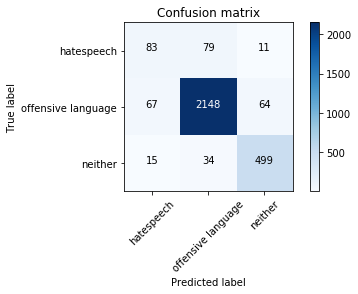

In [129]:
from sklearn.metrics import confusion_matrix
#cm = confusion_matrix(true_labels, yhat)
cm = confusion_matrix(true_labels, yhat)
CLASSES = ["hatespeech", "offensive language", "neither"]
plot_confusion_matrix(cm, CLASSES)

In [ ]:
{'eval_accuracy': 0.9182136,
 'false_negatives': 79.0,
 'false_positives': 128.0,
 'loss': 0.35960054,
 'precision': 0.9640247,
 'recall': 0.9774865,
 'true_negatives': 80.0,
 'true_positives': 3430.0,
 'global_step': 6505}

### Own F1

In [125]:
results = getPrediction(dev['text'])

INFO:tensorflow:Writing example 0 of 3000


I0410 11:31:37.568359 139649862170432 tf_logging.py:115] Writing example 0 of 3000


INFO:tensorflow:*** Example ***


I0410 11:31:37.572731 139649862170432 tf_logging.py:115] *** Example ***


INFO:tensorflow:guid: 


I0410 11:31:37.576233 139649862170432 tf_logging.py:115] guid: 


INFO:tensorflow:tokens: [CLS] please stop scoring , otherwise you won ' t have any runs for tomorrow against romero # yankees # blue ##ja ##ys # mlb [SEP]


I0410 11:31:37.578361 139649862170432 tf_logging.py:115] tokens: [CLS] please stop scoring , otherwise you won ' t have any runs for tomorrow against romero # yankees # blue ##ja ##ys # mlb [SEP]


INFO:tensorflow:input_ids: 101 3531 2644 4577 1010 4728 2017 2180 1005 1056 2031 2151 3216 2005 4826 2114 18290 1001 11081 1001 2630 3900 7274 1001 10901 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


I0410 11:31:37.579758 139649862170432 tf_logging.py:115] input_ids: 101 3531 2644 4577 1010 4728 2017 2180 1005 1056 2031 2151 3216 2005 4826 2114 18290 1001 11081 1001 2630 3900 7274 1001 10901 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


I0410 11:31:37.580630 139649862170432 tf_logging.py:115] input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


I0410 11:31:37.581490 139649862170432 tf_logging.py:115] segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: 0 (id = 0)


I0410 11:31:37.582231 139649862170432 tf_logging.py:115] label: 0 (id = 0)


INFO:tensorflow:*** Example ***


I0410 11:31:37.583938 139649862170432 tf_logging.py:115] *** Example ***


INFO:tensorflow:guid: 


I0410 11:31:37.584882 139649862170432 tf_logging.py:115] guid: 


INFO:tensorflow:tokens: [CLS] rt mention : if a single wasp could read these # wasp ##fa ##cts t ##wee ##ts there could be a peace treaty between wasps and man but wasps are mention ; [SEP]


I0410 11:31:37.585681 139649862170432 tf_logging.py:115] tokens: [CLS] rt mention : if a single wasp could read these # wasp ##fa ##cts t ##wee ##ts there could be a peace treaty between wasps and man but wasps are mention ; [SEP]


INFO:tensorflow:input_ids: 101 19387 5254 1024 2065 1037 2309 19411 2071 3191 2122 1001 19411 7011 16649 1056 28394 3215 2045 2071 2022 1037 3521 5036 2090 23146 1998 2158 2021 23146 2024 5254 1025 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


I0410 11:31:37.586692 139649862170432 tf_logging.py:115] input_ids: 101 19387 5254 1024 2065 1037 2309 19411 2071 3191 2122 1001 19411 7011 16649 1056 28394 3215 2045 2071 2022 1037 3521 5036 2090 23146 1998 2158 2021 23146 2024 5254 1025 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


I0410 11:31:37.587995 139649862170432 tf_logging.py:115] input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


I0410 11:31:37.589096 139649862170432 tf_logging.py:115] segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: 0 (id = 0)


I0410 11:31:37.589957 139649862170432 tf_logging.py:115] label: 0 (id = 0)


INFO:tensorflow:*** Example ***


I0410 11:31:37.591103 139649862170432 tf_logging.py:115] *** Example ***


INFO:tensorflow:guid: 


I0410 11:31:37.591860 139649862170432 tf_logging.py:115] guid: 


INFO:tensorflow:tokens: [CLS] still waiting for o ##om ##f to hit that ho ##e lo ##lo ##lo ##l [SEP]


I0410 11:31:37.592644 139649862170432 tf_logging.py:115] tokens: [CLS] still waiting for o ##om ##f to hit that ho ##e lo ##lo ##lo ##l [SEP]


INFO:tensorflow:input_ids: 101 2145 3403 2005 1051 5358 2546 2000 2718 2008 7570 2063 8840 4135 4135 2140 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


I0410 11:31:37.593338 139649862170432 tf_logging.py:115] input_ids: 101 2145 3403 2005 1051 5358 2546 2000 2718 2008 7570 2063 8840 4135 4135 2140 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


I0410 11:31:37.594096 139649862170432 tf_logging.py:115] input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


I0410 11:31:37.594850 139649862170432 tf_logging.py:115] segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: 0 (id = 0)


I0410 11:31:37.595674 139649862170432 tf_logging.py:115] label: 0 (id = 0)


INFO:tensorflow:*** Example ***


I0410 11:31:37.598329 139649862170432 tf_logging.py:115] *** Example ***


INFO:tensorflow:guid: 


I0410 11:31:37.599947 139649862170432 tf_logging.py:115] guid: 


INFO:tensorflow:tokens: [CLS] mention i agree the fat bitch ##es the only girls left not get ##tin passed around [SEP]


I0410 11:31:37.600940 139649862170432 tf_logging.py:115] tokens: [CLS] mention i agree the fat bitch ##es the only girls left not get ##tin passed around [SEP]


INFO:tensorflow:input_ids: 101 5254 1045 5993 1996 6638 7743 2229 1996 2069 3057 2187 2025 2131 7629 2979 2105 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


I0410 11:31:37.601664 139649862170432 tf_logging.py:115] input_ids: 101 5254 1045 5993 1996 6638 7743 2229 1996 2069 3057 2187 2025 2131 7629 2979 2105 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


I0410 11:31:37.602443 139649862170432 tf_logging.py:115] input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


I0410 11:31:37.603073 139649862170432 tf_logging.py:115] segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: 0 (id = 0)


I0410 11:31:37.603677 139649862170432 tf_logging.py:115] label: 0 (id = 0)


INFO:tensorflow:*** Example ***


I0410 11:31:37.604627 139649862170432 tf_logging.py:115] *** Example ***


INFO:tensorflow:guid: 


I0410 11:31:37.605733 139649862170432 tf_logging.py:115] guid: 


INFO:tensorflow:tokens: [CLS] rt mention : me and mention are in our yellow submarine rn . . mention ; [SEP]


I0410 11:31:37.606511 139649862170432 tf_logging.py:115] tokens: [CLS] rt mention : me and mention are in our yellow submarine rn . . mention ; [SEP]


INFO:tensorflow:input_ids: 101 19387 5254 1024 2033 1998 5254 2024 1999 2256 3756 6982 29300 1012 1012 5254 1025 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


I0410 11:31:37.607357 139649862170432 tf_logging.py:115] input_ids: 101 19387 5254 1024 2033 1998 5254 2024 1999 2256 3756 6982 29300 1012 1012 5254 1025 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


I0410 11:31:37.607975 139649862170432 tf_logging.py:115] input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


I0410 11:31:37.608554 139649862170432 tf_logging.py:115] segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: 0 (id = 0)


I0410 11:31:37.609121 139649862170432 tf_logging.py:115] label: 0 (id = 0)


INFO:tensorflow:Calling model_fn.


I0410 11:31:40.094075 139649862170432 tf_logging.py:115] Calling model_fn.


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0410 11:31:42.952617 139649862170432 tf_logging.py:115] Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Done calling model_fn.


I0410 11:31:43.097992 139649862170432 tf_logging.py:115] Done calling model_fn.


INFO:tensorflow:Graph was finalized.


I0410 11:31:43.650909 139649862170432 tf_logging.py:115] Graph was finalized.


INFO:tensorflow:Restoring parameters from tf-hub-output/model.ckpt-562


I0410 11:31:43.656433 139649862170432 tf_logging.py:115] Restoring parameters from tf-hub-output/model.ckpt-562


INFO:tensorflow:Running local_init_op.


I0410 11:31:44.219020 139649862170432 tf_logging.py:115] Running local_init_op.


INFO:tensorflow:Done running local_init_op.


I0410 11:31:44.273758 139649862170432 tf_logging.py:115] Done running local_init_op.


In [460]:
true_labels = test['label'].astype(int)  # they are type object, turn to int
yhat = pd.DataFrame(results)[2]

f1_score(true_labels, yhat, average='micro')

0.9173333333333333

### extra test

In [465]:
# turn list probabilities into label
def argmax(lst):
  return lst.index(max(lst))
argmax(probs[0])

1

In [464]:
comb2 = pd.read_json(basefolder+'output/combined.json')
probs = combined['bert3k']

In [466]:
yhat2 = probs.apply(lambda x: argmax(x))

In [469]:
f1_score(yhat2, yhat, average='micro')

0.9966666666666667

### Test

In [472]:
results_test = getPrediction(test['text'])


INFO:tensorflow:Writing example 0 of 3000


I0410 14:53:34.577359 139649862170432 tf_logging.py:115] Writing example 0 of 3000


INFO:tensorflow:*** Example ***


I0410 14:53:34.580783 139649862170432 tf_logging.py:115] *** Example ***


INFO:tensorflow:guid: 


I0410 14:53:34.582962 139649862170432 tf_logging.py:115] guid: 


INFO:tensorflow:tokens: [CLS] wizard turned into a ho ##e after a break up [SEP]


I0410 14:53:34.584884 139649862170432 tf_logging.py:115] tokens: [CLS] wizard turned into a ho ##e after a break up [SEP]


INFO:tensorflow:input_ids: 101 10276 2357 2046 1037 7570 2063 2044 1037 3338 2039 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


I0410 14:53:34.586852 139649862170432 tf_logging.py:115] input_ids: 101 10276 2357 2046 1037 7570 2063 2044 1037 3338 2039 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


I0410 14:53:34.588803 139649862170432 tf_logging.py:115] input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


I0410 14:53:34.590777 139649862170432 tf_logging.py:115] segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: 0 (id = 0)


I0410 14:53:34.592188 139649862170432 tf_logging.py:115] label: 0 (id = 0)


INFO:tensorflow:*** Example ***


I0410 14:53:34.593760 139649862170432 tf_logging.py:115] *** Example ***


INFO:tensorflow:guid: 


I0410 14:53:34.594606 139649862170432 tf_logging.py:115] guid: 


INFO:tensorflow:tokens: [CLS] rt mention : captain kirk ho ##e ! [SEP]


I0410 14:53:34.595478 139649862170432 tf_logging.py:115] tokens: [CLS] rt mention : captain kirk ho ##e ! [SEP]


INFO:tensorflow:input_ids: 101 19387 5254 1024 2952 11332 7570 2063 999 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


I0410 14:53:34.596402 139649862170432 tf_logging.py:115] input_ids: 101 19387 5254 1024 2952 11332 7570 2063 999 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


I0410 14:53:34.597414 139649862170432 tf_logging.py:115] input_mask: 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


I0410 14:53:34.598596 139649862170432 tf_logging.py:115] segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: 0 (id = 0)


I0410 14:53:34.599418 139649862170432 tf_logging.py:115] label: 0 (id = 0)


INFO:tensorflow:*** Example ***


I0410 14:53:34.600814 139649862170432 tf_logging.py:115] *** Example ***


INFO:tensorflow:guid: 


I0410 14:53:34.601749 139649862170432 tf_logging.py:115] guid: 


INFO:tensorflow:tokens: [CLS] mention br ##uh did go out like a bitch tho ##e lo ##l that should not be his final match [SEP]


I0410 14:53:34.602588 139649862170432 tf_logging.py:115] tokens: [CLS] mention br ##uh did go out like a bitch tho ##e lo ##l that should not be his final match [SEP]


INFO:tensorflow:input_ids: 101 5254 7987 27225 2106 2175 2041 2066 1037 7743 27793 2063 8840 2140 2008 2323 2025 2022 2010 2345 2674 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


I0410 14:53:34.603549 139649862170432 tf_logging.py:115] input_ids: 101 5254 7987 27225 2106 2175 2041 2066 1037 7743 27793 2063 8840 2140 2008 2323 2025 2022 2010 2345 2674 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


I0410 14:53:34.604410 139649862170432 tf_logging.py:115] input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


I0410 14:53:34.605280 139649862170432 tf_logging.py:115] segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: 0 (id = 0)


I0410 14:53:34.606085 139649862170432 tf_logging.py:115] label: 0 (id = 0)


INFO:tensorflow:*** Example ***


I0410 14:53:34.607400 139649862170432 tf_logging.py:115] *** Example ***


INFO:tensorflow:guid: 


I0410 14:53:34.608197 139649862170432 tf_logging.py:115] guid: 


INFO:tensorflow:tokens: [CLS] rt mention : rt mention : when you try ##na get bitch ##es on linked ##in ur ##l [SEP]


I0410 14:53:34.609064 139649862170432 tf_logging.py:115] tokens: [CLS] rt mention : rt mention : when you try ##na get bitch ##es on linked ##in ur ##l [SEP]


INFO:tensorflow:input_ids: 101 19387 5254 1024 19387 5254 1024 2043 2017 3046 2532 2131 7743 2229 2006 5799 2378 24471 2140 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


I0410 14:53:34.609937 139649862170432 tf_logging.py:115] input_ids: 101 19387 5254 1024 19387 5254 1024 2043 2017 3046 2532 2131 7743 2229 2006 5799 2378 24471 2140 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


I0410 14:53:34.610866 139649862170432 tf_logging.py:115] input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


I0410 14:53:34.611735 139649862170432 tf_logging.py:115] segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: 0 (id = 0)


I0410 14:53:34.612564 139649862170432 tf_logging.py:115] label: 0 (id = 0)


INFO:tensorflow:*** Example ***


I0410 14:53:34.613978 139649862170432 tf_logging.py:115] *** Example ***


INFO:tensorflow:guid: 


I0410 14:53:34.614942 139649862170432 tf_logging.py:115] guid: 


INFO:tensorflow:tokens: [CLS] well i wish i could shoot the shit wit u bitch ##es but daddy gotta get di ##s money . one [SEP]


I0410 14:53:34.615812 139649862170432 tf_logging.py:115] tokens: [CLS] well i wish i could shoot the shit wit u bitch ##es but daddy gotta get di ##s money . one [SEP]


INFO:tensorflow:input_ids: 101 2092 1045 4299 1045 2071 5607 1996 4485 15966 1057 7743 2229 2021 8600 10657 2131 4487 2015 2769 1012 2028 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


I0410 14:53:34.616712 139649862170432 tf_logging.py:115] input_ids: 101 2092 1045 4299 1045 2071 5607 1996 4485 15966 1057 7743 2229 2021 8600 10657 2131 4487 2015 2769 1012 2028 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


I0410 14:53:34.617601 139649862170432 tf_logging.py:115] input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


I0410 14:53:34.618498 139649862170432 tf_logging.py:115] segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: 0 (id = 0)


I0410 14:53:34.619338 139649862170432 tf_logging.py:115] label: 0 (id = 0)


INFO:tensorflow:Calling model_fn.


I0410 14:53:37.430452 139649862170432 tf_logging.py:115] Calling model_fn.


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0410 14:53:39.963447 139649862170432 tf_logging.py:115] Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Done calling model_fn.


I0410 14:53:40.116277 139649862170432 tf_logging.py:115] Done calling model_fn.


INFO:tensorflow:Graph was finalized.


I0410 14:53:40.513663 139649862170432 tf_logging.py:115] Graph was finalized.


INFO:tensorflow:Restoring parameters from tf-hub-output/model.ckpt-1687


I0410 14:53:40.517659 139649862170432 tf_logging.py:115] Restoring parameters from tf-hub-output/model.ckpt-1687


INFO:tensorflow:Running local_init_op.


I0410 14:53:41.044101 139649862170432 tf_logging.py:115] Running local_init_op.


INFO:tensorflow:Done running local_init_op.


I0410 14:53:41.096965 139649862170432 tf_logging.py:115] Done running local_init_op.


In [496]:
true_labels = test['label'].astype(int)  # they are type object, turn to int
yhat = pd.DataFrame(results_test)[2]

f1_score(true_labels, yhat, average='micro')

0.9166666666666666

In [91]:
from sklearn.metrics import f1_score
f1_score(true_labels, yhat, average='micro')

0.8916666666666667

[[   0  173]
 [   0 2827]]


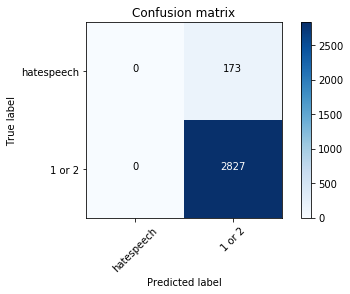

In [96]:
from sklearn.metrics import confusion_matrix
#cm = confusion_matrix(true_labels, yhat)
cm = confusion_matrix(true_labels2, yhat2)
CLASSES = ["hatespeech", "1 or 2"]
plot_confusion_matrix(cm, CLASSES)